# Produce IRF from test MC DL2 (all-sky MC production) with `lstchain_create_irf_files`

Create instrument response functions (IRF) in FITS format, from **test MC DL2** files assuming certain **selection cuts and event filtering** using the `lstchain_create_irf_files` Tool.

Its usage and input arguments are described in the `--help` docstring (`--help-all` for a more detailed description of all the input arguments):
```
$ lstchain_create_irf_files --help
```

This notebook explains how to produce a **[point-like IRF](https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/point_like/index.html)** needed to perform a 1D analysis with Gammapy, from gamma-ray *testing* MC DL2 files.

As a reminder, here is the overall view of the MC products from [**lstmcpipe**](https://cta-observatory.github.io/lstmcpipe/pipeline.html). The standard DL1/DL2 MC files are separated as *testing* and *training* files, where the DL1 *training* files are used to train the Random Forest models for the reconstruction of DL1 files to DL2, and DL2 *testing* files are used for producing the IRFs, which, together with the gamma-ray-like selected event list, comprise the DL3, the science-ready data products.

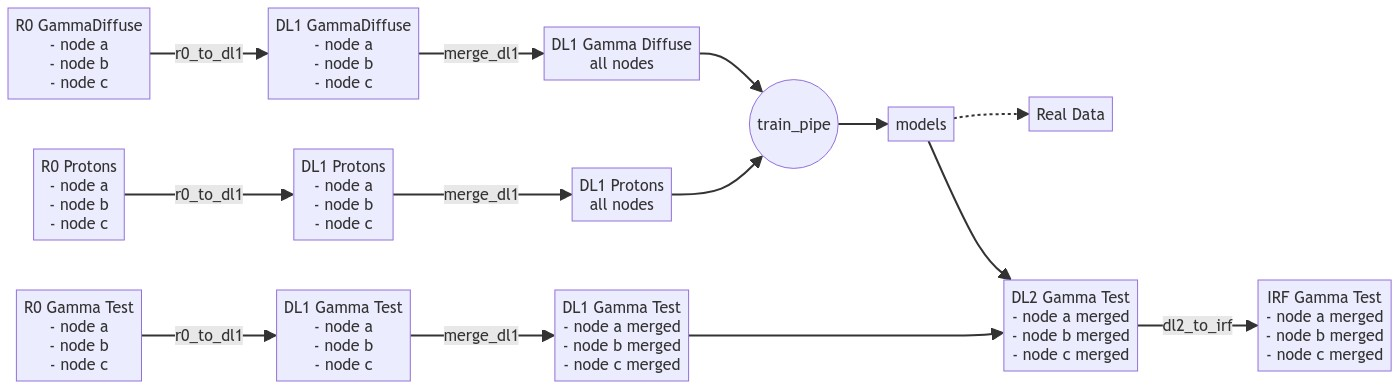


The training/testing MC samples are produced in discrete sky-pointing directions across the whole sky:
 - Training MC pointing nodes (circle markers) are produced along several declination lines.
 - Testing MC nodes are produced in a regular triangular grid in cos(zenith angle) and B⊥/B (star markers).

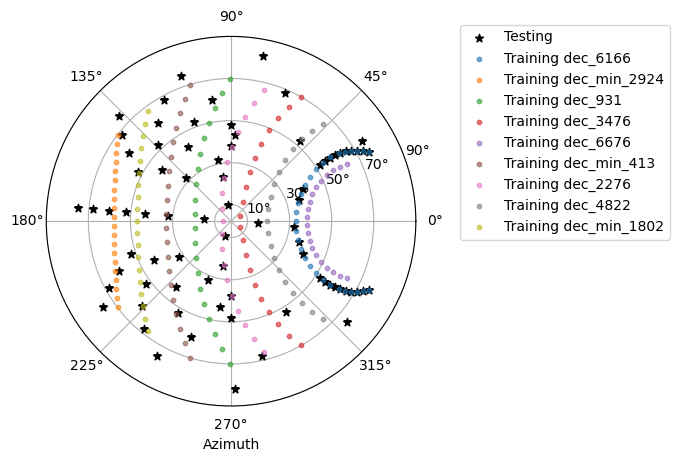

In this notebook, we calculate the IRF for each of these testing MC nodes. Then, **for any telescope pointing, the IRFs are interpolated**, a step that is done later by the `lstchain_create_dl3_file` Tool (for lstchain > v0.10.x).

For the **selection of the gamma-like events** that are going to be used for the IRF calculation, there is a first selection based on certain filters (e.g. minimum intensity value), and later a set of selection cuts on *gammaness* and *theta*/*alpha*, which can be either fixed global cuts or energy-dependent cuts with a certain gamma-ray efficiency and containment region. **Important:** The same selection cuts should be used for the DL3 gamma-like event list production.

For the use of the Tool, we also need a **config file providing the event selection cuts and binning information**. One can use the example config file available in [`cta-lstchain/docs/examples/irf_tool_config.json`](https://github.com/cta-observatory/cta-lstchain/blob/main/docs/examples/irf_tool_config.json) or create a similar config file for each specific use case. If the config file is not provided, the default values are used as per the Component in the file `cta-lstchain/lstchain/io/event_selection.py`.

**Warning:** The production of *[full-enclosure IRF](https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/full_enclosure/index.html#full-enclosure-irfs)* is also possible with this tool but we need diffuse gamma-ray MC DL2 (not being generated currently in the all-sky MC standard production). Also, background IRF may be calculated if proton and electron MC are provided. These two cases are not covered in this notebook.

In [2]:
%matplotlib inline
from astropy.io import fits
import astropy.units as u
from astropy.table import QTable

import matplotlib.pyplot as plt
from traitlets.config.loader import Config

from gammapy.irf import EnergyDispersion2D, EffectiveAreaTable2D
from lstchain.io.config import read_configuration_file
from pathlib import Path
import subprocess

# Standard all-sky DL2 test MC
It is in: `/fefs/aswg/data/mc/DL2/AllSky` where you can see all the available productions.

**Important:** You should use v0.10* productions if you are using lstchain v0.10*, v0.9 MC productions cannot be analyzed with lstchain v0.10

In [3]:
# Using the standard all-sky MC files
mc_base_dir = Path("/fefs/aswg/data/mc/DL2/AllSky")

For this example, let's use one of the latest all-sky base productions:
`20230901_v0.10.4_allsky_base_prod`

Each production has at least one directory indicating the declination line. In this case, we use `dec_2276` so the full path would be:
```
/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_2276
```
Finally, inside this directory, you will find multiple subfolders corresponding to each simulated pointing node with a merged test gamma DL2 MC file (see all-sky plot at the beginning of this notebook).

We will produce IRF files from each of these for all the nodes and store them in a directory for use later by the DL3 Tool.

In [4]:
! ls {mc_base_dir}/20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_2276/node_theta_10.0_az_102.199_

dl1_dl2-27325085.e
dl1_dl2-27325085.o
dl2_20230901_v0.10.4_allsky_base_prod_node_theta_10.0_az_102.199__merged.h5
lstchain_config_2023-09-01.json


In [5]:
# Define the output directory to store the produced IRFs node-wise
# irf_output_dir = Path("/fefs/aswg/workspace/analysis-school-2024/DL2_to_DL3/IRF")
irf_output_dir = Path("./output/DL2_to_DL3/IRF")
irf_output_dir.mkdir(exist_ok=True, parents=True)

In [6]:
# Directory containing all the nodes subfolders
mc_prod = "20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_3476"
dl2_test_mc_dir = mc_base_dir / mc_prod 

# Settings for the tool

By default, `lstchain_create_irf_files` assumes global cuts in gammaness and theta. Here we will use energy-dependent cuts based on a certain gamma-ray selection cut efficiency (activating the flags `--energy-dependent-gh` and `--energy-dependent-theta`). These dynamic cuts are calculated from the gamma-ray DL2 MC.

Input arguments can be specified by command line or via the config file. Let's assume the defaults for this example.

In [7]:
# irf_config_file = "../docs/examples/irf_tool_config.json"
irf_config_file = "/fefs/aswg/workspace/analysis-school-2024/cta-lstchain/docs/examples/irf_tool_config.json"
config = Config(read_configuration_file(irf_config_file))
config

{'EventSelector': {'filters': {'intensity': [50, inf],
   'width': [0, inf],
   'length': [0, inf],
   'r': [0, 1],
   'wl': [0.01, 1],
   'leakage_intensity_width_2': [0, 1],
   'event_type': [32, 32]}},
 'DL3Cuts': {'min_event_p_en_bin': 100,
  'global_gh_cut': 0.7,
  'gh_efficiency': 0.7,
  'min_gh_cut': 0.1,
  'max_gh_cut': 0.98,
  'global_alpha_cut': 10,
  'global_theta_cut': 0.2,
  'theta_containment': 0.7,
  'alpha_containment': 0.7,
  'min_theta_cut': 0.1,
  'max_theta_cut': 0.32,
  'fill_theta_cut': 0.32,
  'min_alpha_cut': 1,
  'max_alpha_cut': 20,
  'fill_alpha_cut': 20,
  'allowed_tels': [1]},
 'DataBinning': {'true_energy_min': 0.005,
  'true_energy_max': 500,
  'true_energy_n_bins': 25,
  'reco_energy_min': 0.005,
  'reco_energy_max': 500,
  'reco_energy_n_bins': 25,
  'energy_migration_min': 0.2,
  'energy_migration_max': 5,
  'energy_migration_n_bins': 30,
  'fov_offset_min': 0.1,
  'fov_offset_max': 1.1,
  'fov_offset_n_edges': 9,
  'bkg_fov_offset_min': 0,
  'bkg_fov_

# Running the tool

The way of running the IRF creation tool for a given DL2 file is:

```
$lstchain_create_irf_files \
 --point-like \
 --input-gamma-dl2=/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_3476/node_theta_73.142_az_331.979_/dl2_20230901_v0.10.4_allsky_base_prod_node_theta_73.142_az_331.979__merged.h5 \
 --output-irf-file=/fefs/aswg/workspace/analysis-school-2024/DL2_to_DL3/IRF/irf_node_theta_73.142_az_331.979_.fits.gz \
 --config=../docs/examples/irf_tool_config.json \
 --log-file=/fefs/aswg/workspace/analysis-school-2024/DL2_to_DL3/IRF/log/irf_tool_irf_node_theta_73.142_az_331.979_.fits.log \
 --energy-dependent-gh \
 --energy-dependent-theta \
 --overwrite
```

# Example of running the tool for each MC node using SLURM
The production of each IRF usually takes around 1 min. Here we schedule all jobs so they are produced in parallel.

In [8]:
# Loop over the nodes inside each MC declination-line test DL2 directory
# to create an IRF file for each MC node and a given value of gammaness efficiency and theta containment

nodes = dl2_test_mc_dir.glob("node_*")

log_dir = irf_output_dir / "log"
log_dir.mkdir(exist_ok=True, parents=True)

for node in nodes:

    try:  # Look for the DL2 test MC file
        dl2_mc_gamma = next(node.glob("dl2_*__merged.h5"))
    except StopIteration:
        log.warning(f"Missing DL2 MC file in {node.name}")
        
    irf_file = irf_output_dir / f"irf_{node.name}.fits.gz"  # We include the node in the filename to differentiate between IRF files

    log_file = log_dir / f"{irf_file.stem}.log"
    
    sbatch_cmd = [
        "sbatch",
        "--mem-per-cpu=12GB"
    ]
    
    lstchain_cmd = [
        "lstchain_create_irf_files",
        "--point-like",
        f"--input-gamma-dl2={dl2_mc_gamma}",
        f"--output-irf-file={irf_file}",
        f"--config={irf_config_file}",
        f"--log-file={log_file}",
        "--energy-dependent-gh",
        "--energy-dependent-theta",
        "--overwrite",
    ]

    print(" \\\n ".join(lstchain_cmd))  # If you want to check how the actual command looks

    # subprocess.run(sbatch_cmd + lstchain_cmd)  # Uncomment this line, but be careful! This will submit tens of jobs


lstchain_create_irf_files \
 --point-like \
 --input-gamma-dl2=/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_3476/node_theta_73.142_az_331.979_/dl2_20230901_v0.10.4_allsky_base_prod_node_theta_73.142_az_331.979__merged.h5 \
 --output-irf-file=DL2_to_DL3/IRF/irf_node_theta_73.142_az_331.979_.fits.gz \
 --config=/fefs/aswg/workspace/analysis-school-2024/cta-lstchain/docs/examples/irf_tool_config.json \
 --log-file=DL2_to_DL3/IRF/log/irf_node_theta_73.142_az_331.979_.fits.log \
 --energy-dependent-gh \
 --energy-dependent-theta \
 --overwrite
lstchain_create_irf_files \
 --point-like \
 --input-gamma-dl2=/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_3476/node_theta_70.732_az_330.659_/dl2_20230901_v0.10.4_allsky_base_prod_node_theta_70.732_az_330.659__merged.h5 \
 --output-irf-file=DL2_to_DL3/IRF/irf_node_theta_70.732_az_330.659_.fits.gz \
 --config=/fefs/aswg/workspace/analysis-school-2024/cta-lstchain/docs/examples




# Check the point-like IRFs with some basic plots
Let's have a look at one of these IRF files:

In [9]:
irf_file = Path("/fefs/aswg/workspace/analysis-school-2024/DL2_to_DL3/IRF/irf_node_theta_23.630_az_100.758_.fits.gz")

In [10]:
fits.open(irf_file).info()

Filename: /fefs/aswg/workspace/analysis-school-2024/DL2_to_DL3/IRF/irf_node_theta_23.630_az_100.758_.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EFFECTIVE AREA    1 BinTableHDU     49   1R x 5C   [25D, 25D, D, D, 25D]   
  2  ENERGY DISPERSION    1 BinTableHDU     55   1R x 7C   [25D, 25D, 30D, 30D, D, D, 750D]   
  3  GH_CUTS       1 BinTableHDU     35   25R x 5C   [D, D, D, K, D]   
  4  RAD_MAX       1 BinTableHDU     49   1R x 5C   [25D, 25D, D, D, 25D]   


In [11]:
aeff_plot = EffectiveAreaTable2D.read(irf_file, hdu="EFFECTIVE AREA")
edisp_plot = EnergyDispersion2D.read(irf_file, hdu="ENERGY DISPERSION")

# Since we have use energy-dependent gh and theta cuts:
gh_cut = QTable.read(irf_file, hdu="GH_CUTS")
theta_cut = QTable.read(irf_file, hdu="RAD_MAX")

In [12]:
# Sample header values for IRFs
fits.open(irf_file)["ENERGY DISPERSION"].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6896 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
CREATOR = 'pyirf v0.10.1'                                                       
HDUDOC  = 'https://github.com/open-gamma-ray-astro/gamma-astro-data-formats'    
HDUVERS = '0.2     '                                                            
HDUCLASS= 'GADF    '                                                            
HDUCLAS1= 'RESPONSE'        

# Effective area

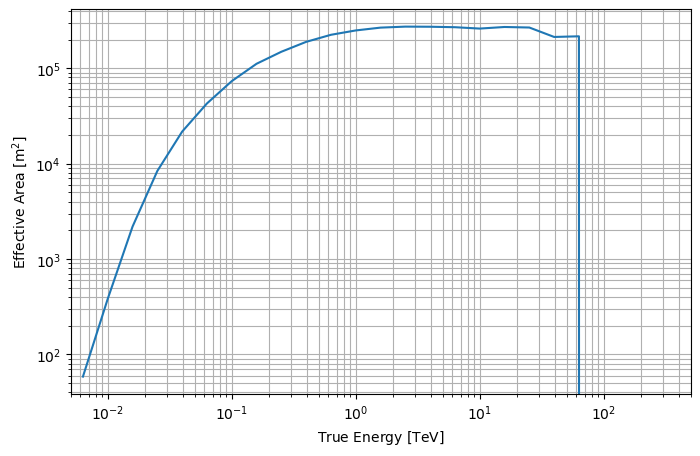

In [23]:
# Effective Area energy dependence
plt.figure(figsize=(8,5))

aeff_plot.plot_energy_dependence(offset=[0.4 * u.deg])
plt.legend().remove()
plt.yscale('log')
plt.grid(which='both')

Text(0.5, 1.0, 'Effective Area - energy offset dependence')

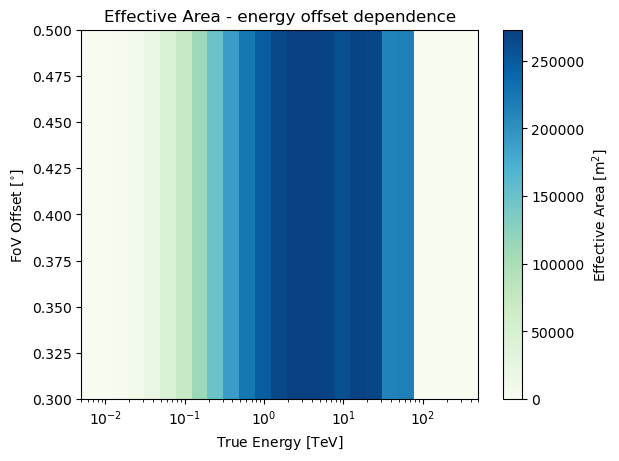

In [42]:
# Energy Offset dependence
aeff_plot.plot()
plt.title("Effective Area - energy offset dependence")

# Energy dispersion and energy bias

Text(0.5, 0.98, 'Energy migration')

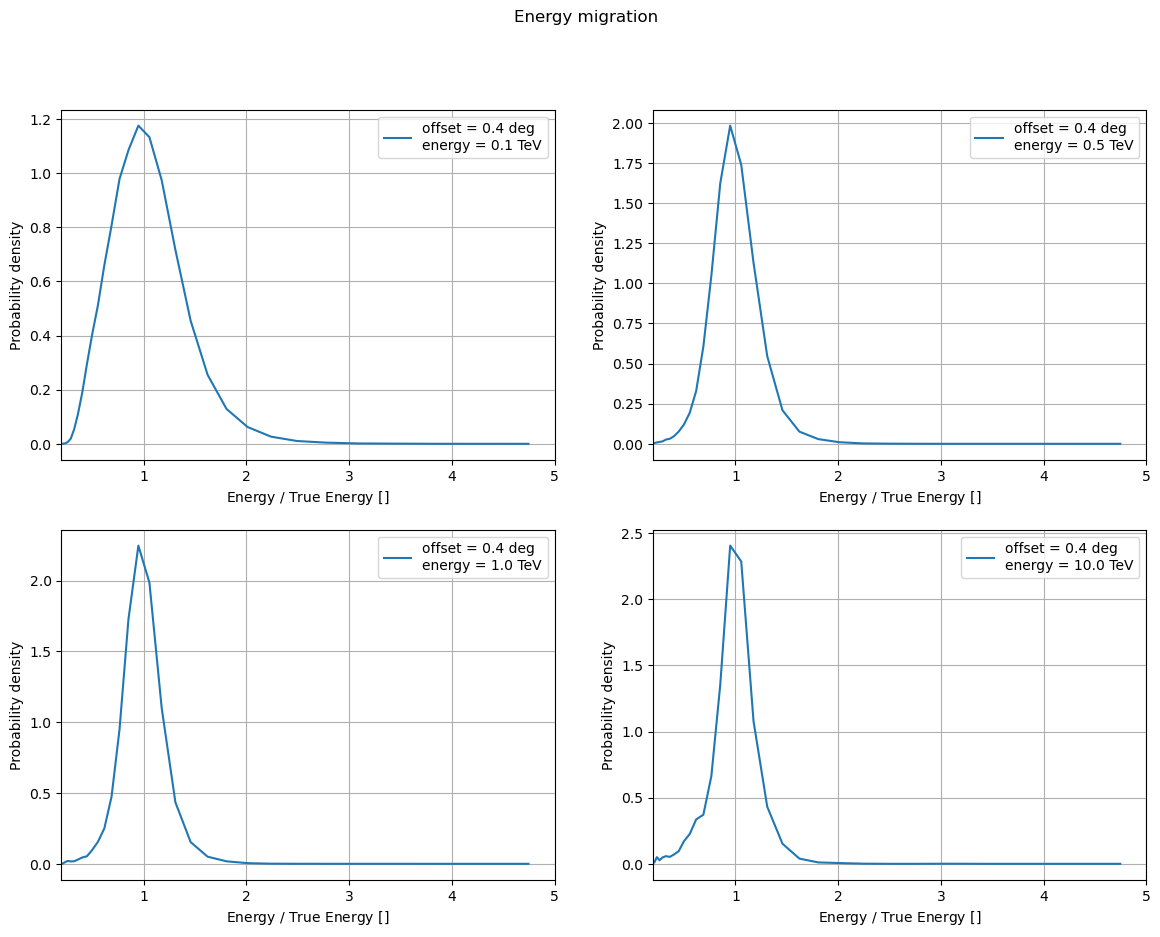

In [47]:
# Energy Dispersion, energy migration
plt.figure(figsize=(14,10))

offset = "0.4 deg"
true_energy = [0.1, 0.5, 1, 10] * u.TeV

plt.subplot(221)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[0])
plt.legend(loc=1)
plt.grid()

plt.subplot(222)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[1])
plt.legend(loc=1)
plt.grid()

plt.subplot(223)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[2])
plt.legend(loc=1)
plt.grid()

plt.subplot(224)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[3])
plt.legend(loc=1)
plt.grid()

plt.suptitle("Energy migration")

Text(0.5, 1.0, 'Energy Bias at 0.4 deg')

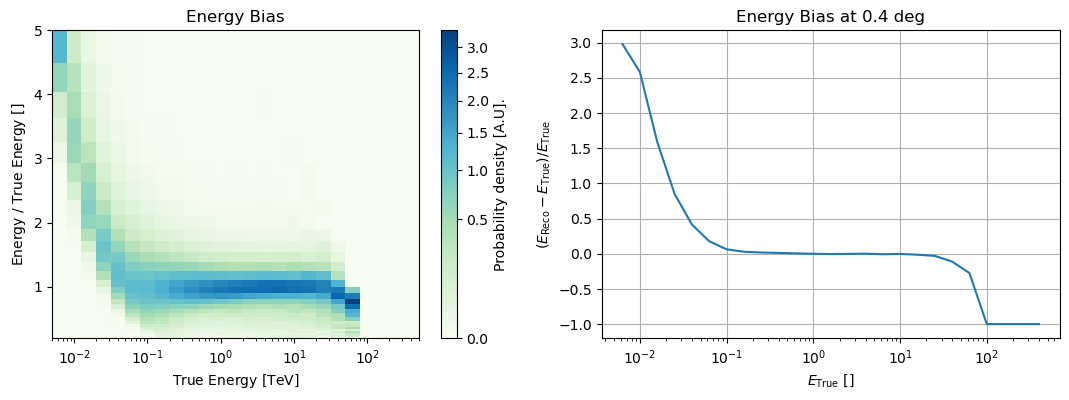

In [44]:
# Energy bias

plt.figure(figsize=(13, 4))

plt.subplot(121)
edisp_plot.plot_bias(offset=offset, add_cbar=True)
plt.title("Energy Bias")

plt.subplot(122)
edisp_kernel = edisp_plot.to_edisp_kernel(offset=0.4*u.deg)
edisp_kernel.plot_bias()
plt.grid()
plt.title("Energy Bias at 0.4 deg")

Text(0.5, 1.0, 'Energy Migration Matrix')

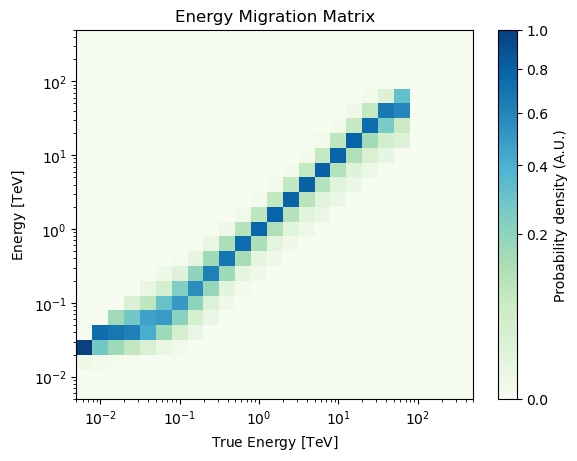

In [45]:
# Energy migration matrix
edisp_kernel.plot_matrix(add_cbar=True)
plt.title("Energy Migration Matrix")

# Energy-dependent gammaness cuts

In [48]:
gh_cut.meta 

OrderedDict([('CREATOR', 'lstchain v0.10.7.dev16+g7ad812a.d20240129'),
             ('DATE', '2024-02-06 19:05:00.863'),
             ('TELESCOP', 'CTA-N'),
             ('INSTRUME', 'LST-1'),
             ('FOVALIGN', 'RADEC'),
             ('ZEN_PNT', 23.63),
             ('AZ_PNT', 100.758),
             ('B_TOTAL', 38.592769622802734),
             ('B_INC', 0.6519277095794678),
             ('B_DEC', -0.08447393774986267),
             ('B_DELTA', 50.093786472690894),
             ('GH_EFF', 0.9),
             ('TH_CONT', 0.68),
             ('EXTNAME', 'GH_CUTS')])

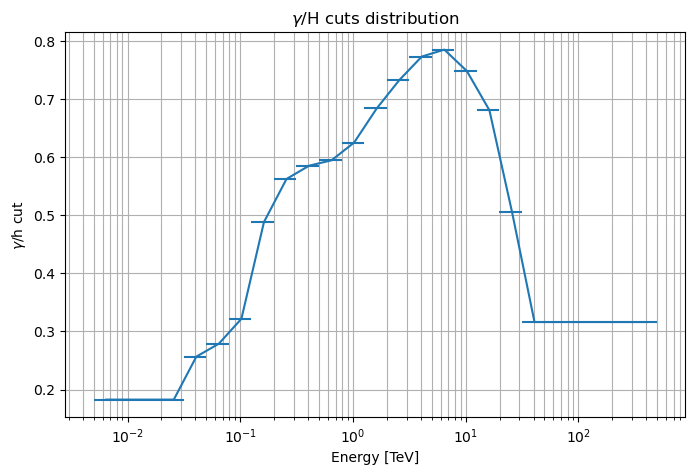

In [49]:
plt.figure(figsize=(8,5))

plt.errorbar(
    gh_cut["center"], gh_cut["cut"],
    xerr=(
        gh_cut["center"] - gh_cut["low"], 
        gh_cut["high"] - gh_cut["center"]
    )
)

plt.xscale('log')
plt.title(r"$\gamma$/H cuts distribution")
plt.ylabel(r'$\gamma$/h cut')
plt.xlabel('Energy [TeV]')
plt.grid(which='both')

# Energy-dependent theta cuts

In [50]:
theta_cut.meta

OrderedDict([('CREATOR', 'pyirf v0.10.1'),
             ('HDUDOC',
              'https://github.com/open-gamma-ray-astro/gamma-astro-data-formats'),
             ('HDUVERS', '0.2'),
             ('HDUCLASS', 'GADF'),
             ('HDUCLAS1', 'RESPONSE'),
             ('HDUCLAS2', 'RAD_MAX'),
             ('HDUCLAS3', 'POINT-LIKE'),
             ('HDUCLAS4', 'RAD_MAX_2D'),
             ('DATE', '2024-02-06 19:05:00.873'),
             ('TELESCOP', 'CTA-N'),
             ('INSTRUME', 'LST-1'),
             ('FOVALIGN', 'RADEC'),
             ('ZEN_PNT', 23.63),
             ('AZ_PNT', 100.758),
             ('B_TOTAL', 38.592769622802734),
             ('B_INC', 0.6519277095794678),
             ('B_DEC', -0.08447393774986267),
             ('B_DELTA', 50.093786472690894),
             ('GH_EFF', 0.9),
             ('TH_CONT', 0.68),
             ('EXTNAME', 'RAD_MAX')])

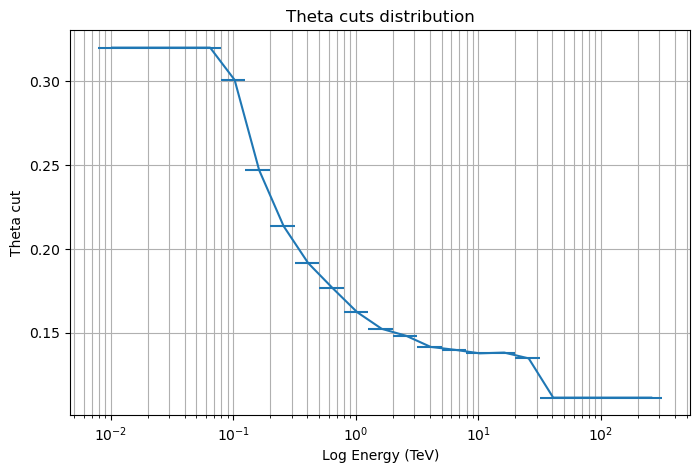

In [51]:
plt.figure(figsize=(8,5))
plt.errorbar(
    0.5 * (theta_cut[0]['ENERG_LO'] + theta_cut[0]['ENERG_HI'])[1:-1],
    theta_cut[0]['RAD_MAX'].T[1:-1, 0],
    xerr=0.5 * (theta_cut[0]['ENERG_HI'] - theta_cut[0]['ENERG_LO'])[1:-1]
)
plt.xscale('log')
plt.title("Theta cuts distribution")
plt.ylabel('Theta cut')
plt.xlabel('Log Energy (TeV)')
plt.grid(which='both')

# Next step (DL2 to DL3): 
Use all these IRF files and the observed DL2 data to produce DL3 files using IRF interpolation (see DL2_to_DL3.ipynb)

In case you are not using IRF interpolation (not recommended), for each data run you should use the IRF file from the nearest test MC node.
In the plot below, each dot corresponds to a Crab data run and the crosses to the closest test MC nodes for which IRF are calculated.

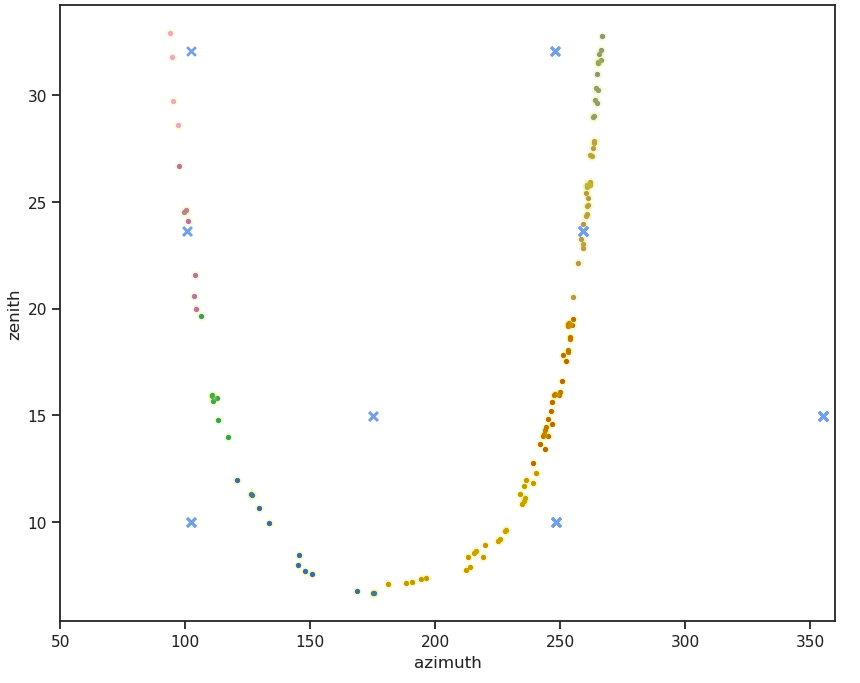


There is no standard tool in lstchain to achieve this matching of the nearest IRF pointing node and observed DL2 data run-average telescope pointing.

# Appendix: choose nearest MC nodes (if no IRF interpolation is done)
Look into the DL1 datacheck to access the run-averaged telescope pointing information for a given set of Crab runs from a single night.

In [49]:
import pandas as pd
import numpy as np
from lstmcpipe.config import paths_config
import os

In [31]:
runsummary = pd.read_hdf("/fefs/aswg/data/real/OSA/DL1DataCheck_LongTerm/v0.10/20231213/DL1_datacheck_20231213.h5", 'runsummary')

In [37]:
run_list = [16069, 16070, 16071, 16072, 16073, 16074, 16075]
runsummary_crab = runsummary[[run in run_list for run in runsummary['runnumber']]]

In [50]:
dec_list = os.listdir("/fefs/aswg/data/models/AllSky/20230901_v0.10.4_allsky_base_prod")

In [51]:
config = paths_config.PathConfigAllSkyFull('all_decs', dec_list)

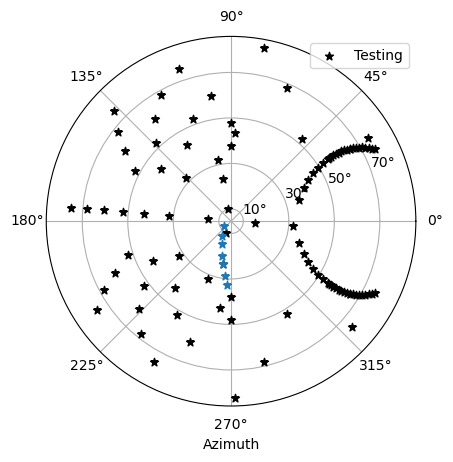

In [80]:
ax = config.test_configs['dec_2276'].plot_pointings(
    marker="*", color="black"
)

ax.scatter(
    runsummary_crab["mean_azimuth"],
    np.pi / 2.0 * u.rad - runsummary_crab["mean_altitude"],
    marker="*",
    label="Crab"
)

In [75]:
test_mc_pointing = config.test_configs['dec_2276'].pointings

In [148]:
test_mc_zenith = (90 * u.deg - test_mc_pointing["alt"]).to_value("deg")
test_mc_azimuth = test_mc_pointing["az"].to_value("deg")
closest_nodes = []

for run, alt, az in zip (run_list, runsummary_crab["mean_altitude"], runsummary_crab["mean_azimuth"]):
    # Compare distance in coszenith:
    zenith = (90 * u.deg - alt * u.rad).to_value("deg")
    azimuth = (az * u.rad).to_value("deg")
    distance = np.abs(np.cos(np.deg2rad(zenith)) - np.cos(np.deg2rad(test_mc_zenith)))

    # Consider only the test MC points on the same side of culmination
    mask = np.array([(((azimuth * u.rad).to_value("deg")-180))*(mc_az-180)>0 for mc_az in test_mc_azimuth])  # >0 means they are both >180 or <180
    distance[~mask] = 1.e6

    closest_zenith = test_mc_zenith[np.argmin(distance)]
    closest_azimuth = test_mc_azimuth[np.argmin(distance)]
    closest_nodes.append([closest_azimuth, closest_zenith])

    print("Run:", run, ", closest node ->, azimuth, zenith:", closest_azimuth, closest_zenith)

Run: 16069 , closest node ->, azimuth, zenith: 248.117 10.0
Run: 16070 , closest node ->, azimuth, zenith: 248.117 10.0
Run: 16071 , closest node ->, azimuth, zenith: 355.158 14.983999999999995
Run: 16072 , closest node ->, azimuth, zenith: 259.265 23.629999999999995
Run: 16073 , closest node ->, azimuth, zenith: 259.265 23.629999999999995
Run: 16074 , closest node ->, azimuth, zenith: 248.099 32.059
Run: 16075 , closest node ->, azimuth, zenith: 248.099 32.059


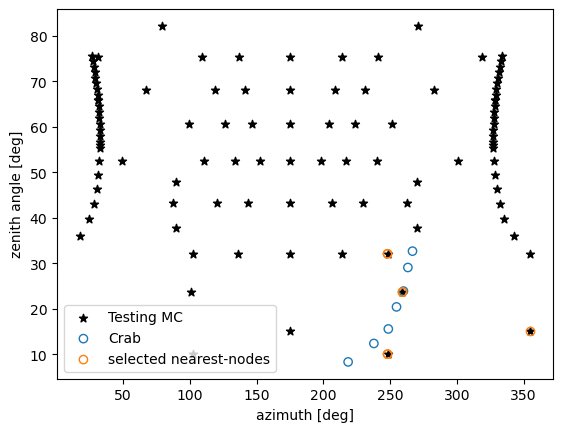

In [167]:
plt.scatter(
    test_mc_pointing["az"],
    90 * u.deg - test_mc_pointing["alt"],
    marker="*", color="black",
    label="Testing MC"
)
plt.scatter(
    np.rad2deg(runsummary_crab["mean_azimuth"]),
    90 - np.rad2deg(runsummary_crab["mean_altitude"]),
    facecolor="none",
    color="C0", label="Crab"
)

# Plot selected nodes
plt.scatter(
    np.stack(closest_nodes, axis=1)[0],
    np.stack(closest_nodes, axis=1)[1],
    facecolor="none", color="C1", label="selected nearest-nodes"
)

plt.xlabel("azimuth [deg]")
plt.ylabel("zenith angle [deg]")
plt.legend()

Finally, observed DL2 data files should be placed in subfolders according to this selection of nearest nodes, along with the corresponding IRF file.